# GTI DIRINT Examples

This notebook shows a few examples of the pvlib python implementation of the GTI DIRINT algorithm.

Authors: Will Holmgren (@wholmgren), University of Arizona (2017).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 5
mpl.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set_color_codes()

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.tools import cosd

pvlib.__version__

'0.5.1+15.gb1a6d48'

Use a clear sky algorithm to generate some POA data.

In [2]:
times = pd.DatetimeIndex(start='20160606', end='20160607', tz='America/Phoenix', freq='1min')

In [3]:
location = Location(32.2, -110.9, altitude=700)

In [4]:
pressure = pvlib.atmosphere.alt2pres(location.altitude)

In [5]:
solpos = location.get_solarposition(times)

In [6]:
cs = location.get_clearsky(times, solar_position=solpos)

In [7]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [8]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [9]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [10]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [11]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [12]:
poa_global = all_irrad['poa_global']

Text(0,0.5,'AOI (deg)')

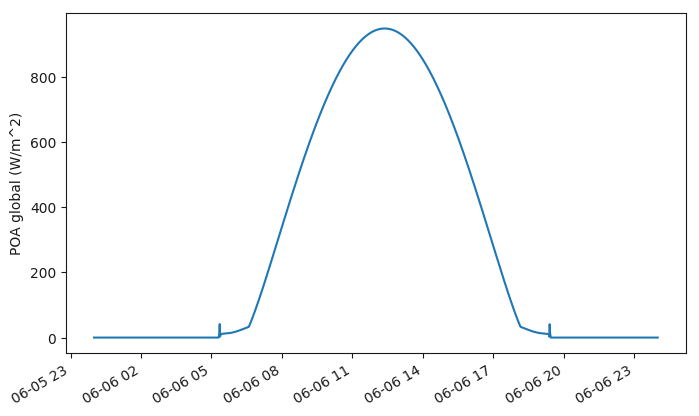

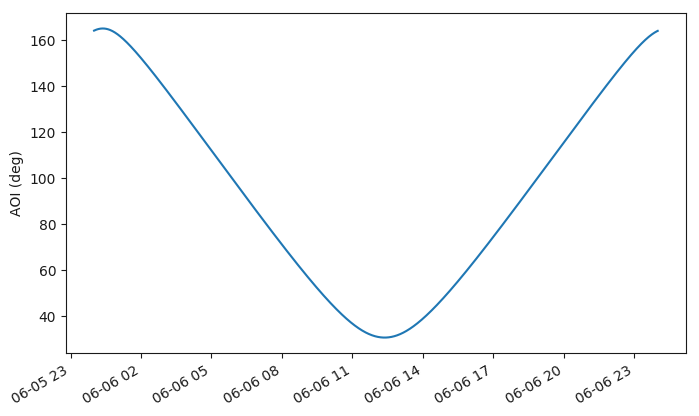

In [13]:
poa_global.plot()
plt.ylabel('POA global (W/m^2)')

plt.figure()
aoi.plot()
plt.ylabel('AOI (deg)')

In [14]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    surface_tilt, surface_azimuth,
    times, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1002: RuntimeWarning: invalid value encountered in less
  ebin[eps < 1.065] = 1
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1005: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.5) & (eps < 1.95)] = 4
/Users/holmgr

Text(0.5,1,'GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

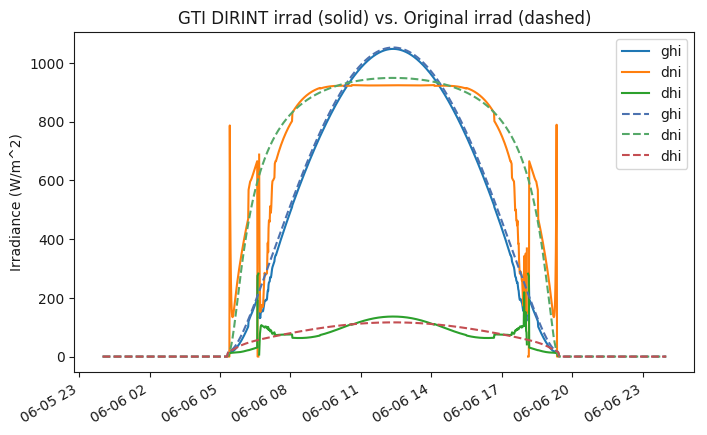

In [15]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax)
cs.plot(ax=ax, ls='--', color=['b', 'g', 'r'])
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

Repeat for summer solstice, fall equinox, winter solstice.

In [16]:
times_jun = pd.DatetimeIndex(start='20160621', end='20160622', tz='America/Phoenix', freq='1min')
times_sep = pd.DatetimeIndex(start='20160921', end='20160922', tz='America/Phoenix', freq='1min')
times_dec = pd.DatetimeIndex(start='20161221', end='20161222', tz='America/Phoenix', freq='1min')

times = times_jun.append(times_sep).append(times_dec)

In [17]:
solpos = location.get_solarposition(times)

In [18]:
cs = location.get_clearsky(times, solar_position=solpos)

In [19]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [20]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [21]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [22]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [23]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [24]:
poa_global = all_irrad['poa_global']

In [25]:
aoi_lt_90 = aoi < 90

In [26]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    surface_tilt, surface_azimuth,
    times, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1002: RuntimeWarning: invalid value encountered in less
  ebin[eps < 1.065] = 1
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1003: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.065) & (eps < 1.23)] = 2
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1004: RuntimeWarning: invalid value encountered in less
  ebin[(eps >= 1.23) & (eps < 1.5)] = 3
/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1005: RuntimeWarning: invalid value encountered in greater_equal
  ebin[(eps >= 1.5) & (eps < 1.95)] = 4
/Users/holmgr

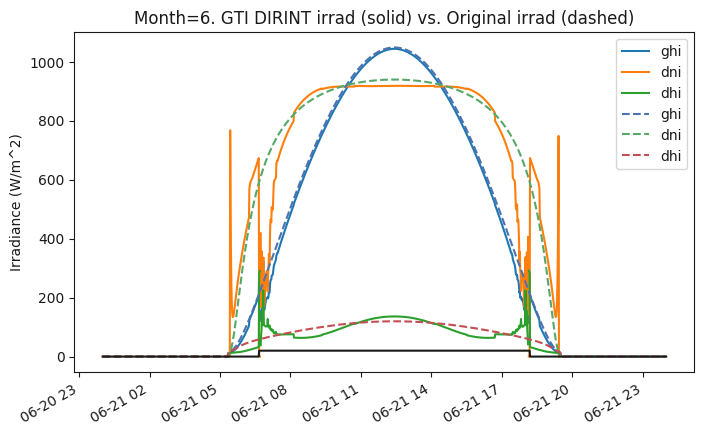

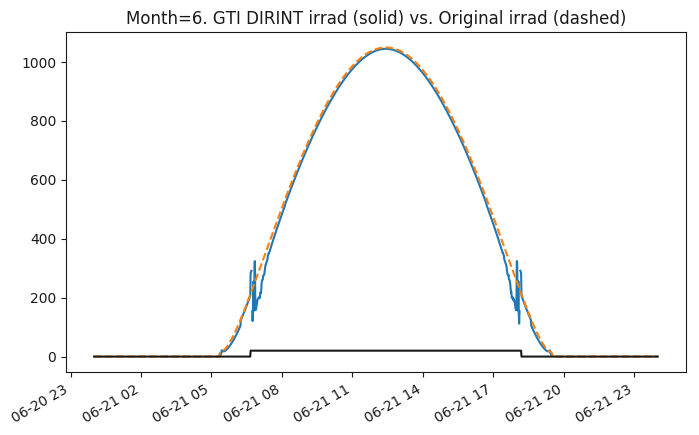

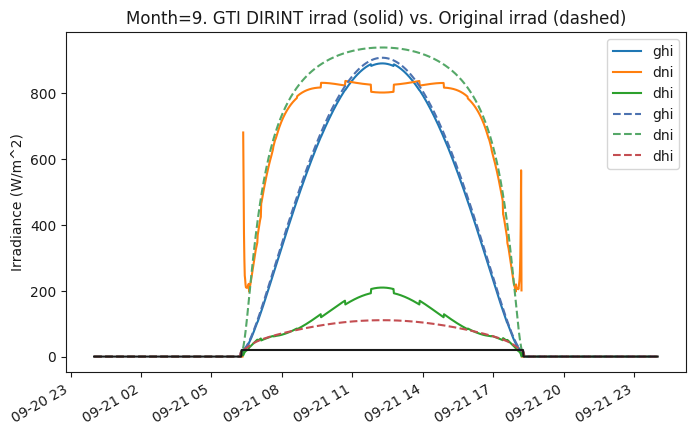

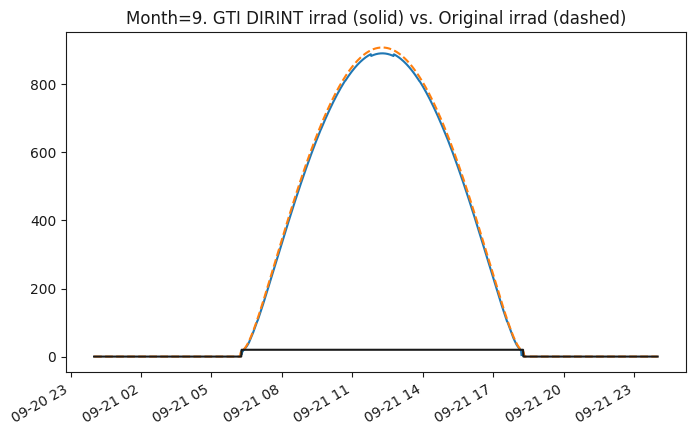

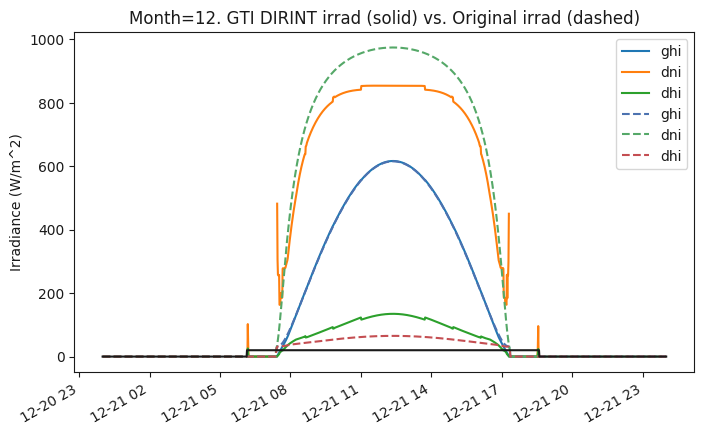

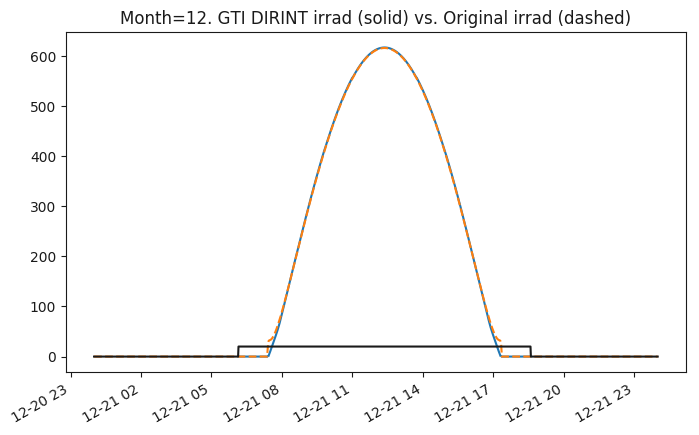

In [27]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax)
    cs.loc[data.index].plot(ax=ax, ls='--', color=['b', 'g', 'r'])
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))